# ImageSet Extended Examples

A large group of images captured using a RedEdge over a central California orchard are available for [download here](https://s3-us-west-2.amazonaws.com/sample.micasense.com/imageprocessing/RedEdgeImageSet.zip).

With this set extracted to a working folder, this notebook will load all of the images in the set and provide more usage examples of ImageSet data.

## Load a directory of images into an ImageSet

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import sys, time, os, datetime
from platform import python_version

print(f"(Sys version) :|: {sys.version} :|:")
os.system("which python")
print(f"(Python version) :#: {python_version()} :#:")

(Sys version) :|: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)] :|:
(Python version) :#: 3.7.12 :#:


In [12]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
import micasense.imageset as imageset
import os, glob
import matplotlib.pyplot as plt

## This progress widget is used for display of the long-running process
f = FloatProgress(min=0, max=1, layout=Layout(width='100%'), description="Loading")
display(f)
def update_f(val):
    if (val - f.value) > 0.005 or val == 1: #reduces cpu usage from updating the progressbar by 10x
        f.value=val

# images_dir = os.path.expanduser(os.path.join('~','Downloads','RedEdgeImageSet','0000SET'))

#Linux filepath
#imagePath = os.path.expanduser(os.path.join('~','Downloads','RedEdge3'))
#Windows filepath
imagePath = os.path.join('r:\\','proc_field','RedEdgeImageSet','0000SET')
panelNames = glob.glob(os.path.join(imagePath,'IMG_0002_*.tif'))

%time imgset = imageset.ImageSet.from_directory(imagePath, progress_callback=update_f)
#imgset = imageset.ImageSet.from_directory(imagePath, progress_callback=update_f)

FloatProgress(value=0.0, description='Loading', layout=Layout(width='100%'), max=1.0)

c:\imageprocessing\micasense\imageset.py:139: PendingDeprecationWarning: The progress_callback parameter will be deprecated in favor of use_tqdm
  category=PendingDeprecationWarning)


Loading ImageSet from: r:\proc_field\RedEdgeImageSet\0000SET
Wall time: 34.4 s


## Import Capture data into Pandas DataFrame

In [13]:
import pandas as pd
data, columns = imgset.as_nested_lists()
print("Columns: {}".format(columns))
df = pd.DataFrame.from_records(data, index='timestamp', columns=columns)

Columns: ['timestamp', 'latitude', 'longitude', 'altitude', 'capture_id', 'dls-yaw', 'dls-pitch', 'dls-roll', 'irr-475', 'irr-560', 'irr-668', 'irr-840', 'irr-717']


## Mapping capture locations using MapboxGL

Below we use the `mapboxgl` extension to plot the measured DLS yaw (or heading) angle from each image's meatadata over the whole imageset. We draw circles at each image location, and then color the circle based on the yaw value. 

In [14]:
import math
import numpy as np
from mapboxgl.viz import *
from mapboxgl.utils import df_to_geojson, create_radius_stops, scale_between
from mapboxgl.utils import create_color_stops

#Insert your mapbox token here
token = 'pk.eyJ1IjoibWljYXNlbnNlIiwiYSI6ImNqYWx5dWNteTJ3cWYzMnBicmZid3g2YzcifQ.Zrq9t7GYocBtBzYyT3P4sw'
color_stops = create_color_stops(np.linspace(-math.pi,math.pi,num=8),colors='YlOrRd')
data = df_to_geojson(df,columns[3:],lat='latitude',lon='longitude')
viz = CircleViz(data, access_token=token, color_property='dls-yaw',
                color_stops=color_stops,
                center=[df['longitude'].median(),df['latitude'].median()], 
                zoom=16, height='600px',
                style='mapbox://styles/mapbox/satellite-streets-v9')
viz.show()
# plt.figure(num=1)

c:\Users\robso\miniconda3\envs\micasense\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Plotting capture metadata

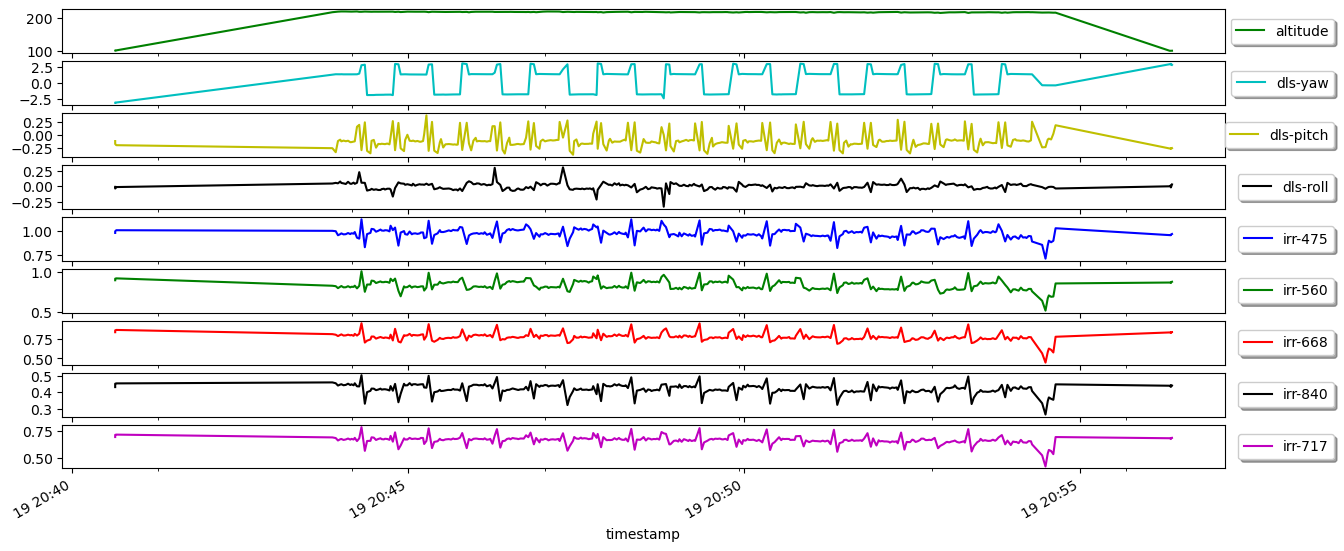

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline

# 'b' as blue |'g' as green | 'r' as red | 'c' as cyan | 'm' as magenta | 'y' as yellow | 'k' as black | 'w' as white
ax=df.plot(y=columns[3:], subplots=True, figsize=(15,6.75), style=['g','c','y','k','b','g','r','k','m'])
for a in ax:
    a.legend(loc='right', bbox_to_anchor=(1.1, 0.5), ncol=1, fancybox=True, shadow=True)
plt.show()
plt.close()

## Separating ground and flight images

We can plot a histogram of the image altitudes for all images in the flight and use the basic statistics to guess at an altitude below which the panel images were likely taken. This can give us an altitude threshold we can apply to separate images taken in flight and on the ground.

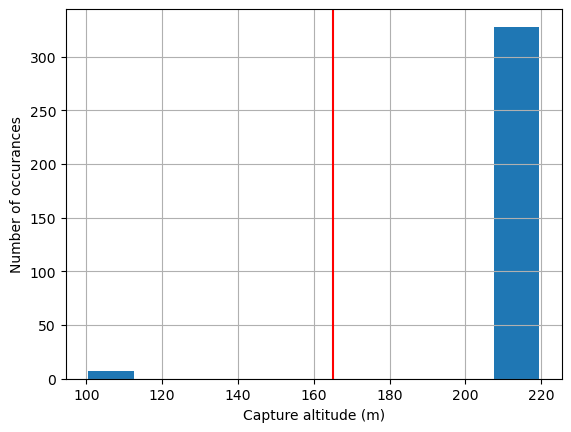

In [16]:
plt.figure(num=3)
# plot the histogram of the altitude data
df.altitude.hist()
# find the altitude above which the flight images occur
cutoff_altitude = df.altitude.mean()-3.0*df.altitude.std()
plt.axvline(x=cutoff_altitude,c='r')
plt.xlabel('Capture altitude (m)')
plt.ylabel('Number of occurances')
plt.show()
plt.close()

## Automatically extracting radiances of panel images
Using the Panel class, we can automatically find and compute the radiance of panel regions within panel images. Each Capture object exposes a `panel_radiance()` method which can be used on panel images to get a list of the radiance of each band (in the native RedEdge band order).

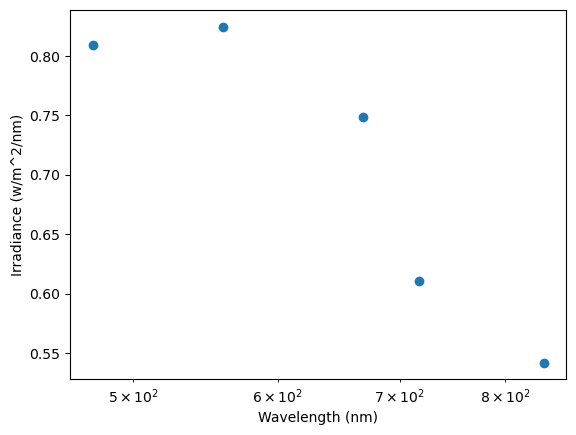

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
import numpy as np

flight = df.altitude>cutoff_altitude
ground = ~flight
ground_idx = np.arange(len(ground))[ground]
flight_idx = np.arange(len(ground))[flight]
ground_captures = np.array(imgset.captures)[ground_idx]
flight_captures = np.array(imgset.captures)[flight_idx]

panel_radiances = []
dls_irradiances = []
panel_timestamps = []
for cap in ground_captures:
    if cap.panels_in_all_expected_images():
        panel_timestamps.append(cap.utc_time())
        panel_radiances.append(cap.panel_radiance())
        dls_irradiances.append(cap.dls_irradiance())

dls_irradiances = np.asarray(dls_irradiances)
panel_radiances = np.asarray(panel_radiances)

panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order
panel_irradiance = ground_captures[0].panel_irradiance(panel_reflectance_by_band)
plt.figure(num=4)
plt.scatter(ground_captures[0].center_wavelengths(), panel_irradiance)
plt.xscale('log')
plt.ylabel("Irradiance (w/m^2/nm)")
plt.xlabel("Wavelength (nm)")
plt.show()
plt.close()
plt.figure(num=4)

## Plotting DLS Irradiances
Once we have extracted the panel radiances from the ground images, we can convert them to irradiance as we did in tutorial #1 and plot the irradiances over time and extract radiance to reflectance conversion factors.

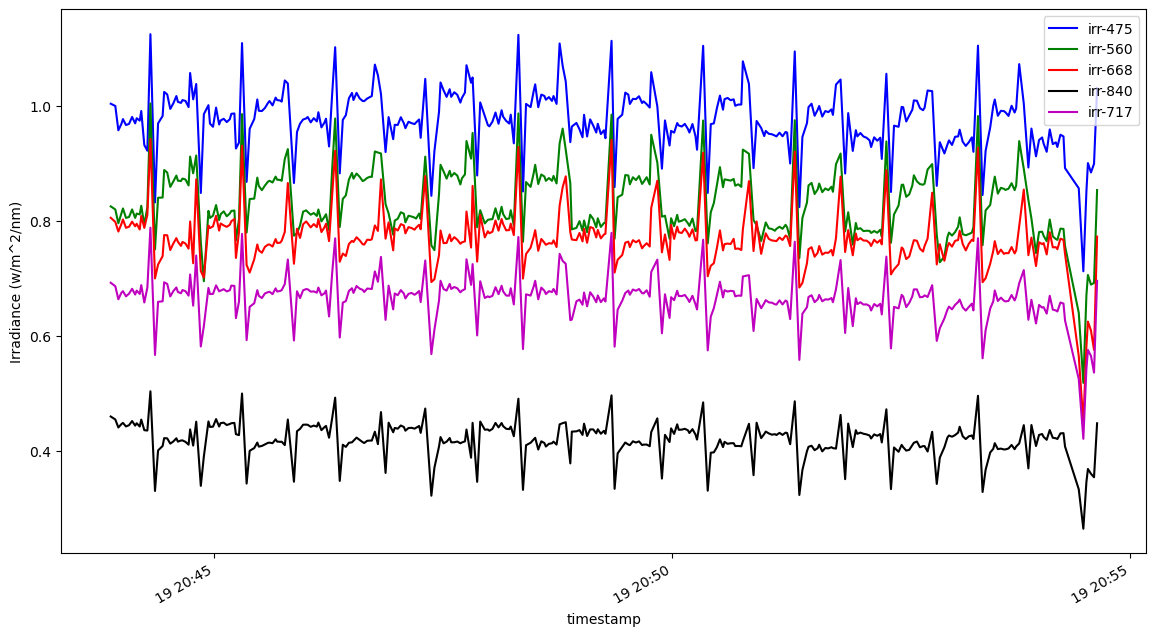

In [18]:
import matplotlib.pyplot as plt
import math

# 'b' as blue |'g' as green | 'r' as red | 'c' as cyan | 'm' as magenta | 'y' as yellow | 'k' as black | 'w' as white
df[df.altitude>cutoff_altitude].plot(y=columns[8:13], figsize=(14,8), style=['b','g','r','k','m'],)
plt.ylabel("Irradiance (w/m^2/nm)")
plt.show()
plt.close()

---
Copyright (c) 2017-2018 MicaSense, Inc.  For licensing information see the [project git repository](https://github.com/micasense/imageprocessing)